In [33]:
import pandas as pd
import numpy as np
import re
import string
import math
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
from matplotlib import pyplot as plt

# Load pickle files

In [34]:
bug_reports_filename = './Output/allBugReports.pickle'
bug_reports_df = pd.read_pickle(bug_reports_filename)

source_code_filename = './Output/allSourceCodes.pickle'
source_code_df = pd.read_pickle(source_code_filename)

# Preprocessing
Source Code Data Pre-processing:
- Remove new lines
- Remove Comments in /* */ notation
- Remove punctuation
- Remove stop words (incuding common java words)
- Stem words
- Clean filenames to match bug report filenames

Bug Report Data Pre-processing:
- Remove new lines
- Remove punctuation
- Remove stop words (incuding common java words)
- Stem words

In [35]:
bug_reports_df.head()


,fix,text,fixdate,summary,description,project,average_precision
id,,,,,,,
23,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-07-31 11:48:16,Searches which returns null gives NPE,A search which returns null gives NullPointerE...,DATAREST,0.0
21,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-07-31 11:49:25,paging with parameters,missing parameter findBy in href .prev and .ne...,DATAREST,0.0
41,[org.springframework.data.rest.webmvc.json.rep...,NaN,2012-09-05 06:07:58,No update on objects,"When I try to update an object, the only think...",DATAREST,0.0
45,[org.springframework.data.rest.webmvc.entityto...,NaN,2012-09-05 06:09:20,No IDs in href of objects displayed,Browsing to: http://localhost:8080/rest/sla re...,DATAREST,0.0
38,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-09-05 06:29:43,Listing relations with Accept:application/x-sp...,When loading a relation like this: \nhttp://lo...,DATAREST,0.0


In [36]:
source_code_df.head()

,filename,unprocessed_code,project
0,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015 the original author or a...,DATAREST
1,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015-2016 the original author...,DATAREST
2,main.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015-2016 the original author...,DATAREST
3,test.java.org.springframework.data.rest.webmvc...,package org.springframework.data.rest.webmvc;\...,DATAREST
4,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2014-2015 the original author...,DATAREST


In [37]:
# Java key words found in https://docs.oracle.com/javase/tutorial/java/nutsandbolts/_keywords.html
java_keywords = ["abstract", "assert**","assert", "boolean", "break", "byte",
 "case", "catch", "char", "const", "continue", "default", "do", "double", "else", "enum",
  "enum****" "extends", "final", "finally", "for", "goto","goto*", "if", "implements", "import", 
  "instanceof", "int","interface", "long", "native", "new", "package", "private", "protected",
   "public", "return", "short", "static", "strictfp**","strictfp", "super", "switch", "synchornized", 
   "this", "throw", "throws", "transient", "try", "void", "volatile", "while"]

# Java operators found in https://www.tutorialspoint.com/java/java_basic_operators.htm
java_operators = ["+", "-", "*", "/", "%", "+=", "-=", "*=", "/=", "++", "--", "==", "!=", "<", ">", 
"<=", ">=", ".", "[", "]", "(",")", "!", "~", "<<", ">>", ">>>", "&", "^", "|", "&&", "||",
 "?", ":", "^=", "%=", "<<=", ">>=", ">>>=", "&="]

java_stop_words = java_keywords + java_operators
ALL_STOP_WORDS = ENGLISH_STOP_WORDS.union(java_stop_words)

In [38]:
# Split camel case text from source code
def split_camel_case(text):
  words = text.split(' ')
  result = []
  
  for word in words:
    if len(word):
      # regex from https://stackoverflow.com/questions/29916065/how-to-do-camelcase-split-in-python
      result = result + re.split("(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])", word)
   
  return ' '.join(result)

# Remove any single or trailing '.' leftover from remove_punctuation() function
def remove_trailing_and_single_dots(text):
  words = text.split(' ')
  result = []
  for word in words:
    if len(word) and word[-1] == '.':
      word = word[:-1]
    if len(word) and word[0] == '.':
      word = word[1:]
    result.append(word)
  
  return ' '.join(result)

# Remove all punctuation except '.'
def remove_comments(text):
  # regex found at https://blog.ostermiller.org/finding-comments-in-source-code-using-regular-expressions/
  result = re.sub("/\*([^*]|[\r\n]|(\*+([^*/]|[\r\n])))*\*+/", '', text)
  return result

# User regex to remove comments using /* */ notation
def remove_punctuation(text):
  punctuation = "/:;<=>?@[\]^_`{|}~!\"#$%&'()*+,-"
  result = re.sub('['+punctuation+']', ' ', text)
  result = remove_trailing_and_single_dots(result)
  result = re.sub("\s+", ' ', result)
  return result

# Remove all new lines from text
def remove_new_lines(text):
  result = []
  for line in text.splitlines():
    if len(line) <= 0:
      continue
    result.append(line)
  result = ' '.join(result)
  result = re.sub('\s+', ' ', result)
  return result

# Remove all stop words and stem remaining words
def stem_words(text):
  stemmer = PorterStemmer()
  words = text.split(' ')
  result = []
  for word in words:
      if word not in ALL_STOP_WORDS:
          result.append(stemmer.stem(word))
  result = ' '.join(result)
  return result

In [39]:
# Start pipeline for cleaning unprocessed code
def clean_unprocessed_code(text):
    # Remove new line breaks
    result = remove_new_lines(text)

    # Remove comments
    result = remove_comments(result)

    # Remove punctuation
    result = remove_punctuation(result)

    # Remove camelCase
    result = split_camel_case(result)

    # Lowercase
    result = result.lower()

    # Stem words
    result = stem_words(result)

    return result.strip()

# Start pipeline for cleaning bug report descriptions
def clean_bug_reports(text):
    if not text:
        return ''
    # Remove new line breaks
    result = remove_new_lines(text)

    # Remove punctuation
    result = remove_punctuation(result)

    # Remove camelCase
    result = split_camel_case(result)

    # Lowercase
    result = result.lower()

    # Stem words
    result = stem_words(result)

    return result.strip()
    

In [40]:
# Clean source code
source_code_df['processed_code'] = source_code_df.unprocessed_code.apply(clean_unprocessed_code)

In [41]:
source_code_df.head()

,filename,unprocessed_code,project,processed_code
0,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015 the original author or a...,DATAREST,org.springframework.data.rest.webmvc.halbrows ...
1,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015-2016 the original author...,DATAREST,org.springframework.data.rest.webmvc.halbrows ...
2,main.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2015-2016 the original author...,DATAREST,org.springframework.data.rest.webmvc.halbrows ...
3,test.java.org.springframework.data.rest.webmvc...,package org.springframework.data.rest.webmvc;\...,DATAREST,org.springframework.data.rest.webmvc org.hamcr...
4,test.java.org.springframework.data.rest.webmvc...,/*\n * Copyright 2014-2015 the original author...,DATAREST,org.springframework.data.rest.webmvc org.hamcr...


In [42]:
# Clean bug reports
bug_reports_df['summary'] = bug_reports_df.summary.apply(clean_bug_reports)
bug_reports_df['description'] = bug_reports_df.description.apply(clean_bug_reports)
bug_reports_df["query"] = bug_reports_df["summary"] + bug_reports_df["description"]

In [43]:
bug_reports_df.head()

,fix,text,fixdate,summary,description,project,average_precision,query
id,,,,,,,,
23,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-07-31 11:48:16,search return null give npe,search return null give null pointer except re...,DATAREST,0.0,search return null give npesearch return null ...
21,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-07-31 11:49:25,page paramet,miss paramet href prev page lt loan info gt ns...,DATAREST,0.0,page parametmiss paramet href prev page lt loa...
41,[org.springframework.data.rest.webmvc.json.rep...,NaN,2012-09-05 06:07:58,updat object,updat object think happen select persist objec...,DATAREST,0.0,updat objectupdat object think happen select p...
45,[org.springframework.data.rest.webmvc.entityto...,NaN,2012-09-05 06:09:20,ds href object display,brows http localhost 8080 rest sla result gist,DATAREST,0.0,ds href object displaybrows http localhost 808...
38,[org.springframework.data.rest.webmvc.reposito...,NaN,2012-09-05 06:29:43,list relat accept applic x spring data compact...,load relat like http localhost 8080 rest entit...,DATAREST,0.0,list relat accept applic x spring data compact...


## Fix Filenames

In [44]:
def fix_sc_filename(sc_df):
    filename = sc_df[0]
    proj = sc_df[2]
    file = filename.split(".")
    if proj == 'IO' or proj == 'COLLECTIONS':
        file = '.'.join(file[1:])
    else:
        file = '.'.join(file[2:])
    return file

In [45]:
# Fix source code filenames
source_code_df['filename'] = source_code_df.apply(fix_sc_filename, axis=1)

# rVSM calculations

In [46]:
projects = source_code_df.project.unique()
source_code_grouped = source_code_df.groupby(source_code_df.project)
bug_reports_grouped = bug_reports_df.groupby(bug_reports_df.project)

In [47]:
print(projects)

['DATAREST' 'CONFIGURATION' 'SEC' 'LDAP' 'IO' 'ELY' 'LANG' 'SPR'
 'DATACMNS' 'SOCIALFB' 'DATAMONGO' 'COLLECTIONS']


## Functions for Calculating Similarity

In [48]:
# Normalize terms using Equation (6)
def normalize_terms(terms):
    x_min = min(terms)
    x_max = max(terms)
    for idx, x in enumerate(terms):
        normalized_term = (x - x_min)/(x_max - x_min)
        terms[idx] = normalized_term

# Run Equation (5) on # of terms
def inverse_logit_function(terms):
    for idx, term in enumerate(terms):
        inverse_term = 1 / (1 + math.exp(-1 * term))
        terms[idx] = inverse_term

# Calculate rVSM function using Equation (7)
def calc_rVSM(document, query, gterms):
    result = cosine_similarity(query, document).flatten()
    for i in range(len(result)):
        result[i] = gterms[i] * result[i]

    return result

# Run pipeline for calculating direct similarities
def check_similarities(source_code, queries):
    scores = []
    vect = TfidfVectorizer(min_df=1).fit(source_code['processed_code'])
    sc_vect = vect.transform(source_code['processed_code'])

    # Get all terms
    terms = []
    for doc in source_code['processed_code']:
        terms.append(len(set(doc.split(' '))))

    # Run Equation (5) and Equation (6)
    normalize_terms(terms)
    inverse_logit_function(terms)
    
    # For each query, calculate similarity that query has to every source code file
    for query in queries['query']:
        qr_vect = vect.transform([query])
        rVSM_score = calc_rVSM(sc_vect, qr_vect, terms)
        scores.append(rVSM_score)

    return scores

## Functions for Evaluation

In [49]:
# Input: 
#   scores: Array of scores created by cosine similarity function
# Output:
#   Array of score indexes sorted in descending order
def rank_scores(scores):
    sorted_scores = np.array(scores).argsort()
    return np.flip(sorted_scores)

# Description: 
#   Map fix files to files in source code (if there is one)
# Input: 
#   fixes: Array of filenames representing the fixes of bugs
#   filenames:  Array of filenames representing the source code files
# Output:
#   result: Array of indexes that map the respective fix file to the file in the source code
def get_fix_index(fixes, filenames):
    result = []
    for fix in fixes:
        fix_index = -1
        for idx, filename in enumerate(filenames):
            if filename == fix:
                fix_index = idx
                break
        result.append(fix_index)
    return result


In [50]:
# Description:
#   Finds where the fix files are in the ranking given by the cosine similarity
# Input: 
#   fixes_idx: Array of indexes created by get_fix_index()
#   file_rankings: Array of indexes created by rank_scores()
# Output:
#   result: Array of indexes that map the fix file to the ranking given by the cosine similarity
def get_fix_rank(fixes_idx, file_rankings):
    result = []
    for fix_idx in fixes_idx:
        for idx, rank in enumerate(file_rankings):
            if fix_idx == rank:
                fix_file_rank = idx + 1
                result.append(fix_file_rank)
                break
    return result

# Description:
#   Calculates the reciprocal rank of the query given the ranks of the cosine similarity
# Input:
#   ranks: Array of indexes created by get_fix_rank()
# Output:
#   returns the reciprocal rank of the query
def calc_reciprocal_rank(ranks):
    sorted_ranks = sorted(ranks)
    if len(sorted_ranks) > 0:
        return 1/(sorted_ranks[0])

# Description:
#   Calcualtes the average precision of the query fiven the ranks of the cosine similarity
# Input:
#   ranks: Array of indexes created by get_fix_rank()
# Output:
#   returns the average accuracy of the query
def calc_mean_average_precision(ranks):
    sorted_ranks = sorted(ranks)
    pos_instances = 0
    result = 0
    for rank in sorted_ranks:
        if rank == sys.maxsize:
            break
        pos_instances += 1
        result += pos_instances/rank
        
    if pos_instances != 0: 
        return result/pos_instances
    else:
        return 0



# Running Scoring and Evaluation Algorithm

In [51]:
# Pipeline for running evaluation for scores
def run_eval(sc_project_df, br_project_df, scores, my_dict):
    fix_rank = []
    reciprocal_rank = []
    average_precision = []

    idx = 0
    for _, row in br_project_df.iterrows():
        ranked_scores = rank_scores(scores[idx])
        fix_index = get_fix_index(row.fix, sc_project_df.filename)
        fix_r = get_fix_rank(fix_index, ranked_scores)
        if len(fix_r) > 0:
            fix_rank.append(fix_r)
            reciprocal_rank.append(calc_reciprocal_rank(fix_r))
            average_precision.append(calc_mean_average_precision(fix_r))
        idx += 1
    
    my_dict['fix_rank'] = fix_rank
    my_dict['reciprocal_rank'] = reciprocal_rank
    my_dict['average_precision'] = average_precision


In [52]:
# Run pipeline for calculating direct similarities and evaluation
def start_alg():
    result = {}
    
    for proj in projects:
        proj_dict = {name: [] for name in ('score', 'fix_rank', 'reciprocal_rank', 'average_precision')}
        sc_project_df = source_code_grouped.get_group(proj)
        br_project_df = bug_reports_grouped.get_group(proj)

        scores = check_similarities(sc_project_df, br_project_df)
        proj_dict['score'] = scores

        run_eval(sc_project_df, br_project_df, scores, proj_dict)

        result[proj] = proj_dict.copy()

    return result

In [53]:
eval_scores = start_alg()

# Visualization

In [54]:
eval_df = pd.DataFrame(eval_scores).transpose()
eval_df.head()

,score,fix_rank,reciprocal_rank,average_precision
DATAREST,"[[0.061959157013992266, 0.07685805325479289, 0...","[[90], [47, 306, 334], [215], [200], [321], [2...","[0.011111111111111112, 0.02127659574468085, 0....","[0.011111111111111112, 0.012264859795080955, 0..."
CONFIGURATION,"[[0.05121419785394934, 0.04454529906745555, 0....","[[29, 3, 6], [5, 1], [41, 8], [14, 45, 1], [10...","[0.3333333333333333, 1.0, 0.125, 1.0, 0.142857...","[0.2567049808429119, 0.7, 0.08689024390243902,..."
SEC,"[[0.10858819224764266, 0.02353029522223805, 0....","[[11], [10, 450, 1, 274], [9, 690, 10, 318], [...","[0.09090909090909091, 1.0, 0.1111111111111111,...","[0.09090909090909091, 0.3049594484995945, 0.08..."
LDAP,"[[0.01327737303976939, 0.013290047030049646, 0...","[[8], [1], [1, 3], [6, 3], [2], [1, 2], [3], [...","[0.125, 1.0, 1.0, 0.3333333333333333, 0.5, 1.0...","[0.125, 1.0, 0.8333333333333333, 0.33333333333..."
IO,"[[0.06221335981731066, 0.011352761496075501, 0...","[[27, 3], [2, 1], [1, 2], [2, 4], [1], [5, 2, ...","[0.3333333333333333, 1.0, 1.0, 0.5, 1.0, 0.5, ...","[0.2037037037037037, 1.0, 1.0, 0.5, 1.0, 0.292..."


In [57]:
def calculate_top_k(ranks, k):
    if len(ranks) <= 0:
        return

    top_k = 0
    # If at least 1 bug is found in top k, then we count it as success (according to research paper)
    for rank in ranks:
        if len(list(filter(lambda r: r <= k, rank))) > 0:
            top_k += 1

    return top_k, top_k/len(ranks) * 100

def create_performance_table(proj_row):
    result = []
    # array to variables
    ranks = proj_row[1]
    rr = proj_row[2]
    ap = proj_row[3]

    # Calculate MRR
    score_MRR = np.mean(rr)
    result.append(score_MRR)

    # Calculate MAP
    score_MAP = np.mean(ap)
    result.append(score_MAP)

    # Calcualte Top 1%
    top_1, top_1_percent = calculate_top_k(ranks, 1)
    result.append(int(top_1))
    result.append(top_1_percent)

    # Calcualte Top 5%
    top_5, top_5_percent = calculate_top_k(ranks, 5)
    result.append(top_5)
    result.append(top_5_percent)

    # Calcualte Top 10%
    top_10, top_10_percent = calculate_top_k(ranks, 10)
    result.append(top_10)
    result.append(top_10_percent)

    return pd.Series(result)

In [58]:
performance_table_df = eval_df.apply(create_performance_table, axis=1)
performance_table_df.columns = ['MRR', 'MAP', 'Top 1', 'Top 1 (%)', 'Top 5', 'Top 5 (%)', 'Top 10', 'Top 10 (%)']

In [59]:
performance_table_df.head(12)

,MRR,MAP,Top 1,Top 1 (%),Top 5,Top 5 (%),Top 10,Top 10 (%)
DATAREST,0.477968,0.317208,41.0,34.453782,75.0,63.025210,89.0,74.789916
CONFIGURATION,0.568746,0.399042,53.0,43.801653,89.0,73.553719,106.0,87.603306
SEC,0.439025,0.349475,107.0,29.888268,223.0,62.290503,262.0,73.184358
LDAP,0.452266,0.353909,16.0,30.769231,31.0,59.615385,35.0,67.307692
IO,0.733792,0.693688,40.0,58.823529,62.0,91.176471,65.0,95.588235
ELY,0.630952,0.630952,3.0,42.857143,7.0,100.000000,7.0,100.000000
LANG,0.664944,0.589924,86.0,53.086420,136.0,83.950617,148.0,91.358025
SPR,0.206290,0.128877,13.0,10.000000,41.0,31.538462,56.0,43.076923
DATACMNS,0.528252,0.415011,58.0,40.000000,97.0,66.896552,107.0,73.793103
SOCIALFB,0.538475,0.436705,6.0,40.000000,10.0,66.666667,13.0,86.666667


In [67]:
def visualize_top_k_percent(df):
    proj_x = df.index.to_numpy()
    top_1 = df['Top 1 (%)'].to_numpy()
    top_5 = df['Top 5 (%)'].to_numpy()
    top_10 = df['Top 10 (%)'].to_numpy()

    x_pos = np.arange(len(proj_x))
    plt.figure(figsize=(20,10))
    plt.xticks(x_pos, proj_x)
    width = 0.25
    plt.title('Top k percentages of bug location ranks')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 110)
    plt.bar(x_pos - width, top_1, width=width, label='Top 1 (%)')
    plt.bar(x_pos, top_5,  width=width, label='Top 5 (%)')
    plt.bar(x_pos + width, top_10,  width=width, label='Top 10 (%)')
    plt.legend()

def visualize_MAP_or_MRR(df, data_metric):
    proj_x = df.index.to_numpy()
    metric = df[data_metric].to_numpy()

    x_pos = np.arange(len(proj_x))
    plt.figure(figsize=(20,10))
    plt.xticks(x_pos, proj_x)
    plt.title(f'{data_metric} for each project')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 1.1)
    plt.bar(x_pos, metric, label=f'{data_metric}')
    plt.legend()

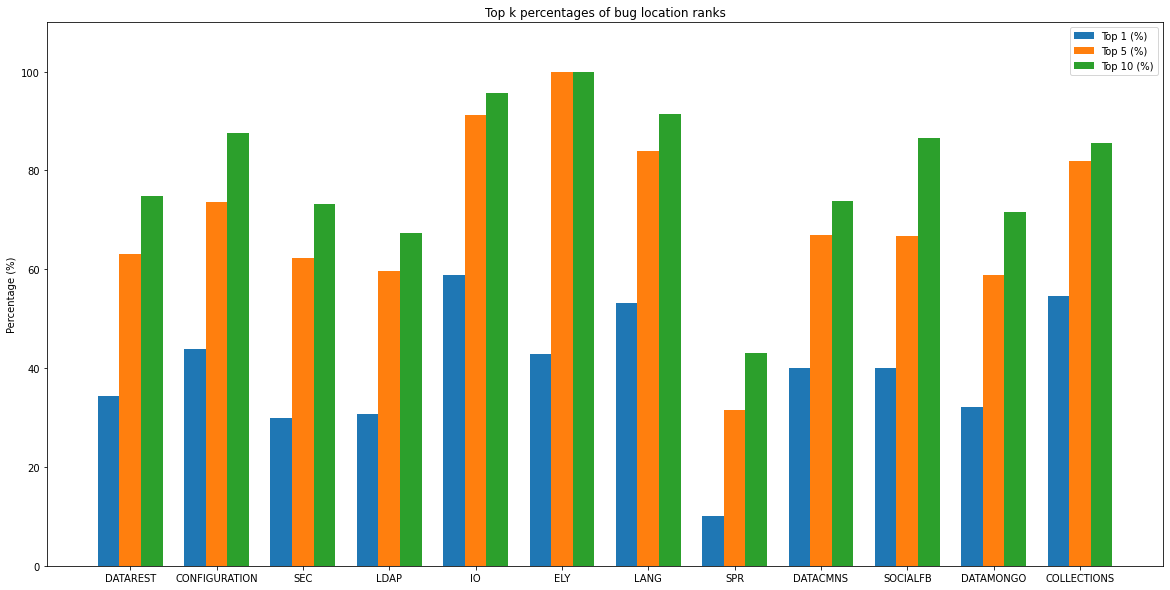

In [61]:
visualize_top_k_percent(performance_table_df)

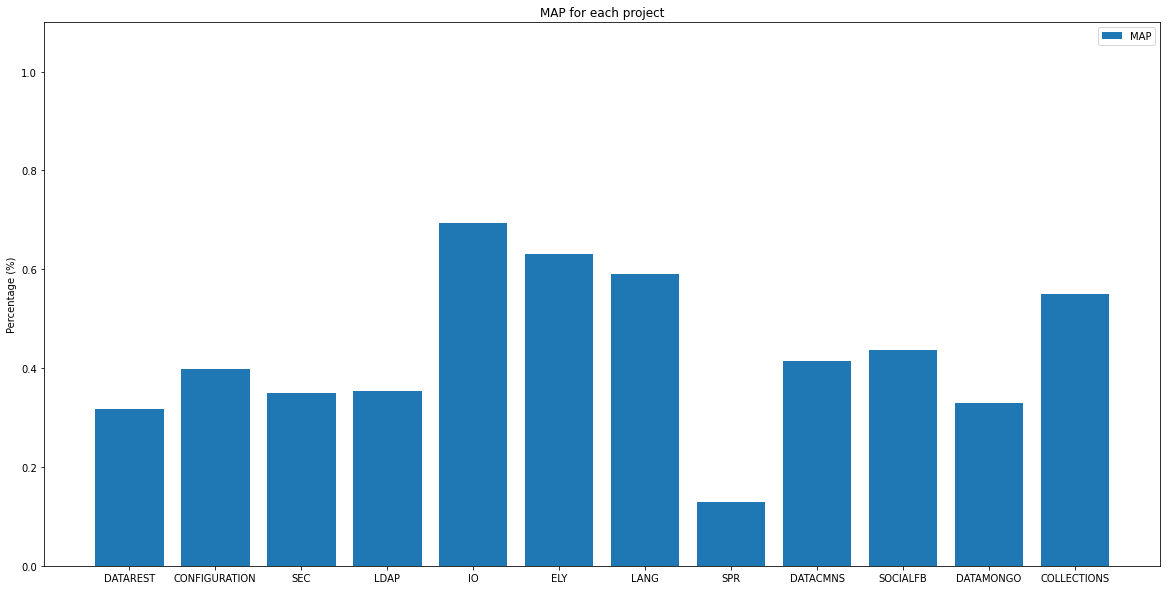

In [68]:
visualize_MAP_or_MRR(performance_table_df, 'MAP')

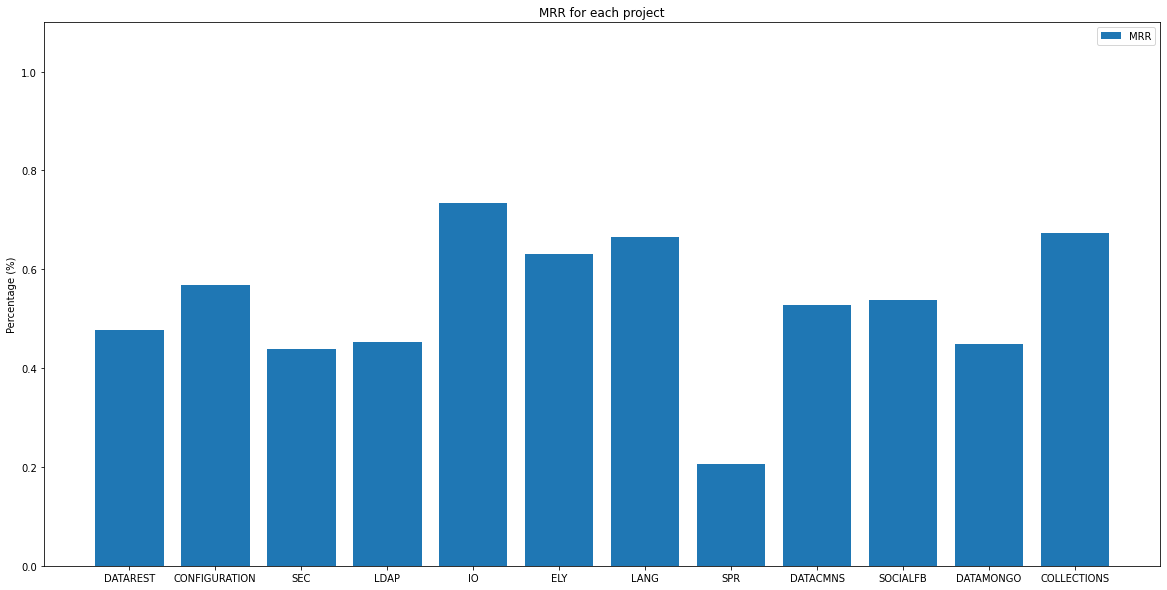

In [69]:
visualize_MAP_or_MRR(performance_table_df, 'MRR')